In [1]:
### We will next go over the python implementation of U-net

In [62]:
### Import libraries

import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
%matplotlib inline
import glob

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,Lambda, concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from scipy.ndimage.measurements import label
import time
from sklearn.metrics import jaccard_similarity_score

import pandas as pd

In [3]:
## Get path where files are to be stored

dir_label = ['images']

In [4]:
### Make data frame in Pandas
train_df = pd.read_csv('../../../train.csv')
train_df['Label'] = "test"
train_df['File_Path'] =  '../../../images/'+train_df['image_name']
train_df.columns = ['Frame', 'xmin', 'xmax', 'ymin','ymax', 'Label', 'File_Path']
train_df = train_df[['File_Path','Frame','Label','ymin','xmin','ymax','xmax']]
train_df.head()

,File_Path,Frame,Label,ymin,xmin,ymax,xmax
0,../../../images/1474724014247DSC07926.png,1474724014247DSC07926.png,test,96,258,381,424
1,../../../images/JPEG_20160623_170956_100088548...,JPEG_20160623_170956_1000885486700.png,test,134,293,359,583
2,../../../images/147185868090020160818_111244.png,147185868090020160818_111244.png,test,2,112,452,478
3,../../../images/JPEG_20160513_115642_100077559...,JPEG_20160513_115642_1000775593523.png,test,168,83,398,589
4,../../../images/JPEG_20161118_133812_100015983...,JPEG_20161118_133812_1000159834754.png,test,0,172,480,519


In [5]:
train_df.tail()

,File_Path,Frame,Label,ymin,xmin,ymax,xmax
12595,../../../images/JPEG_20160711_133315_100093856...,JPEG_20160711_133315_1000938566019.png,test,73,182,423,526
12596,../../../images/JPEG_20160505_163522_100034968...,JPEG_20160505_163522_1000349681451.png,test,108,132,381,533
12597,../../../images/JPEG_20161205_120025_100094659...,JPEG_20161205_120025_1000946595036.png,test,14,63,449,504
12598,../../../images/1480066695304IMG_0064.png,1480066695304IMG_0064.png,test,117,117,286,458
12599,../../../images/1480333117168_R2A3485.png,1480333117168_R2A3485.png,test,106,153,391,497


In [6]:
### Make data frame in Pandas
test_df = pd.read_csv('../../../validation.csv')
test_df['Label'] = "test"
test_df['File_Path'] =  '../../../images/'+test_df['image_name']
test_df.columns = ['Frame', 'xmin', 'xmax', 'ymin','ymax', 'Label', 'File_Path']
test_df = test_df[['File_Path','Frame','Label','ymin','xmin','ymax','xmax']]
test_df.head()

,File_Path,Frame,Label,ymin,xmin,ymax,xmax
0,../../../images/JPEG_20160624_135055_100052716...,JPEG_20160624_135055_1000527160000.png,test,165,132,325,606
1,../../../images/147771890839520161028_141911.png,147771890839520161028_141911.png,test,52,123,452,544
2,../../../images/1474715198275DSC07675.png,1474715198275DSC07675.png,test,32,311,459,458
3,../../../images/JPEG_20161117_112207_100088066...,JPEG_20161117_112207_1000880661419.png,test,5,13,459,640
4,../../../images/147444941744811473248953580-Ro...,147444941744811473248953580-Roadster-Men-Navy-...,test,16,34,471,603


In [7]:
trans_range = 0

In [8]:
### Augmentation functions 

def augment_brightness_camera_images(image):
    
    ### Augment brightness 
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def trans_image(image,bb_boxes_f,trans_range):
    # Translation augmentation
    bb_boxes_f = bb_boxes_f.copy(deep=True)

    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2

    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    rows,cols,channels = image.shape
    bb_boxes_f['xmin'] = (bb_boxes_f['xmin']+tr_x).clip(0,640)
    bb_boxes_f['xmax'] = (bb_boxes_f['xmax']+tr_x).clip(0,640)
    bb_boxes_f['ymin'] = (bb_boxes_f['ymin']+tr_y).clip(0,480)
    bb_boxes_f['ymax'] = (bb_boxes_f['ymax']+tr_y).clip(0,480)
    
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))
    
    return image_tr,bb_boxes_f


def stretch_image(img,bb_boxes_f,scale_range):
    # Stretching augmentation 
    
    bb_boxes_f = bb_boxes_f.copy(deep=True)
    
    tr_x1 = scale_range*np.random.uniform()
    tr_y1 = scale_range*np.random.uniform()
    p1 = (tr_x1,tr_y1)
    tr_x2 = scale_range*np.random.uniform()
    tr_y2 = scale_range*np.random.uniform()
    p2 = (img.shape[1]-tr_x2,tr_y1)

    p3 = (img.shape[1]-tr_x2,img.shape[0]-tr_y2)
    p4 = (tr_x1,img.shape[0]-tr_y2)

    pts1 = np.float32([[p1[0],p1[1]],
                   [p2[0],p2[1]],
                   [p3[0],p3[1]],
                   [p4[0],p4[1]]])
    pts2 = np.float32([[0,0],
                   [img.shape[1],0],
                   [img.shape[1],img.shape[0]],
                   [0,img.shape[0]] ]
                   )

    M = cv2.getPerspectiveTransform(pts1,pts2)
    img = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
    img = np.array(img,dtype=np.uint8)
    
    bb_boxes_f['xmin'] = ((bb_boxes_f['xmin'] - p1[0])/(p2[0]-p1[0])*img.shape[1]).clip(0,640)
    bb_boxes_f['xmax'] = ((bb_boxes_f['xmax'] - p1[0])/(p2[0]-p1[0])*img.shape[1]).clip(0,640)
    bb_boxes_f['ymin'] = ((bb_boxes_f['ymin'] - p1[1])/(p3[1]-p1[1])*img.shape[0]).clip(0,480)
    bb_boxes_f['ymax'] = ((bb_boxes_f['ymax'] - p1[1])/(p3[1]-p1[1])*img.shape[0]).clip(0,480)
    
    return img,bb_boxes_f



def get_image_name(df,ind,size=(640,480),augmentation = False,trans_range = 20,scale_range=20):
    ### Get image by name
    
    file_name = df['File_Path'][ind]
    img = cv2.imread(file_name)
    img_size = np.shape(img)
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,size)
    name_str = file_name.split('/')
    name_str = name_str[-1]
    #print(name_str)
    #print(file_name)
    bb_boxes = df[df['Frame'] == name_str].reset_index()
    img_size_post = np.shape(img)
    
    if augmentation == True:
        img,bb_boxes = trans_image(img,bb_boxes,trans_range)
        img,bb_boxes = stretch_image(img,bb_boxes,scale_range)
        img = augment_brightness_camera_images(img)
        
    bb_boxes['xmin'] = np.round(bb_boxes['xmin']/img_size[1]*img_size_post[1]).clip(0)
    bb_boxes['xmax'] = np.round(bb_boxes['xmax']/img_size[1]*img_size_post[1]).clip(0)
    bb_boxes['ymin'] = np.round(bb_boxes['ymin']/img_size[0]*img_size_post[0]).clip(0)
    bb_boxes['ymax'] = np.round(bb_boxes['ymax']/img_size[0]*img_size_post[0]).clip(0)
    bb_boxes['Area'] = (bb_boxes['xmax']- bb_boxes['xmin'])*(bb_boxes['ymax']- bb_boxes['ymin']) 
    #bb_boxes = bb_boxes[bb_boxes['Area']>400]
        
    
    return name_str,img,bb_boxes


def get_mask_seg(img,bb_boxes_f, size=(640,480)):
    
    #### Get mask 
    
    img_mask = np.zeros_like(img[:,:,0])
    for i in range(len(bb_boxes_f)):
        #plot_bbox(bb_boxes,i,'g')
        bb_box_i = [bb_boxes_f.iloc[i]['xmin'],bb_boxes_f.iloc[i]['ymin'],
                bb_boxes_f.iloc[i]['xmax'],bb_boxes_f.iloc[i]['ymax']]
        bb_box_i = np.array(bb_box_i, dtype='int')
        img_mask[bb_box_i[1]:bb_box_i[3],bb_box_i[0]:bb_box_i[2]] = 1.
        img_mask = np.reshape(img_mask,(np.shape(img_mask)[0],np.shape(img_mask)[1],1))
#         print(img_mask)
    return img_mask

In [9]:
def plot_im_mask(im,im_mask):
    ### Function to plot image mask 
    
    im = np.array(im,dtype=np.uint8)
    im_mask = np.array(im_mask,dtype=np.uint8)
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask));
    plt.axis('off')
    plt.show();
    
def plot_bbox(bb_boxes,ind_bb,color='r',linewidth=2):
    ### Plot bounding box
    
    bb_box_i = [bb_boxes.iloc[ind_bb]['xmin'],
                bb_boxes.iloc[ind_bb]['ymin'],
                bb_boxes.iloc[ind_bb]['xmax'],
                bb_boxes.iloc[ind_bb]['ymax']]
    plt.plot([bb_box_i[0],bb_box_i[2],bb_box_i[2],
                  bb_box_i[0],bb_box_i[0]],
             [bb_box_i[1],bb_box_i[1],bb_box_i[3],
                  bb_box_i[3],bb_box_i[1]],
             color,linewidth=linewidth)
    
def plot_im_bbox(im,bb_boxes):
    ### Plot image and bounding box
    plt.imshow(im)
    for i in range(len(bb_boxes)):
        plot_bbox(bb_boxes,i,'g')
        
        bb_box_i = [bb_boxes.iloc[i]['xmin'],bb_boxes.iloc[i]['ymin'],
                bb_boxes.iloc[i]['xmax'],bb_boxes.iloc[i]['ymax']]
        plt.plot(bb_box_i[0],bb_box_i[1],'rs')
        plt.plot(bb_box_i[2],bb_box_i[3],'bs')
#     plt.axis('off');


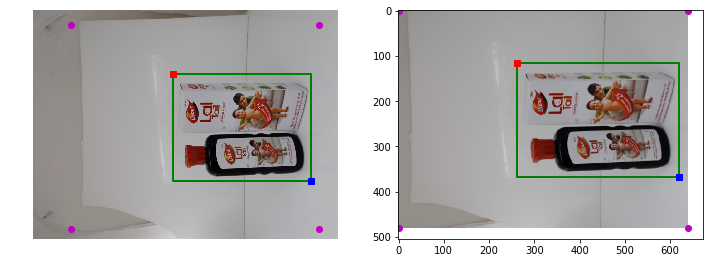

In [10]:
#### Test translation and stretching augmentations

name_str,img,bb_boxes = get_image_name(train_df,1,augmentation=False,trans_range=0,scale_range=0)
img_mask =get_mask_seg(img,bb_boxes)

tr_x1 = 80
tr_y1 = 30
tr_x2 = 40
tr_y2 = 20



p1 = (tr_x1,tr_y1)
p2 = (img.shape[1]-tr_x2,tr_y1)

p3 = (img.shape[1]-tr_x2,img.shape[0]-tr_y2)
p4 = (tr_x1,img.shape[0]-tr_y2)

pts1 = np.float32([[p1[0],p1[1]],
                   [p2[0],p2[1]],
                   [p3[0],p3[1]],
                   [p4[0],p4[1]]])
pts2 = np.float32([[0,0],
                   [img.shape[1],0],
                   [img.shape[1],img.shape[0]],[0,img.shape[0]] ]
                   )

M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]))
dst = np.array(dst,dtype=np.uint8)


plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.plot(p1[0],p1[1],'mo')
plt.plot(p2[0],p2[1],'mo')
plt.plot(p3[0],p3[1],'mo')
plt.plot(p4[0],p4[1],'mo')
for i in range(len(bb_boxes)):
    plot_bbox(bb_boxes,i,'g')
    
    bb_box_i = [bb_boxes.iloc[i]['xmin'],bb_boxes.iloc[i]['ymin'],
                bb_boxes.iloc[i]['xmax'],bb_boxes.iloc[i]['ymax']]
    plt.plot(bb_box_i[0],bb_box_i[1],'rs')
    plt.plot(bb_box_i[2],bb_box_i[3],'bs')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(dst)
bb_boxes1 = bb_boxes.copy(deep=True)
bb_boxes1['xmin'] = (bb_boxes['xmin'] - p1[0])/(p2[0]-p1[0])*img.shape[1]
bb_boxes1['xmax'] = (bb_boxes['xmax'] - p1[0])/(p2[0]-p1[0])*img.shape[1]
bb_boxes1['ymin'] = (bb_boxes['ymin'] - p1[1])/(p3[1]-p1[1])*img.shape[0]
bb_boxes1['ymax'] = (bb_boxes['ymax'] - p1[1])/(p3[1]-p1[1])*img.shape[0]
plt.plot(0,0,'mo')
plt.plot(img.shape[1],0,'mo')
plt.plot(img.shape[1],img.shape[0],'mo')
plt.plot(0,img.shape[0],'mo')
plot_im_bbox(dst,bb_boxes1)

# plt.axis('off');


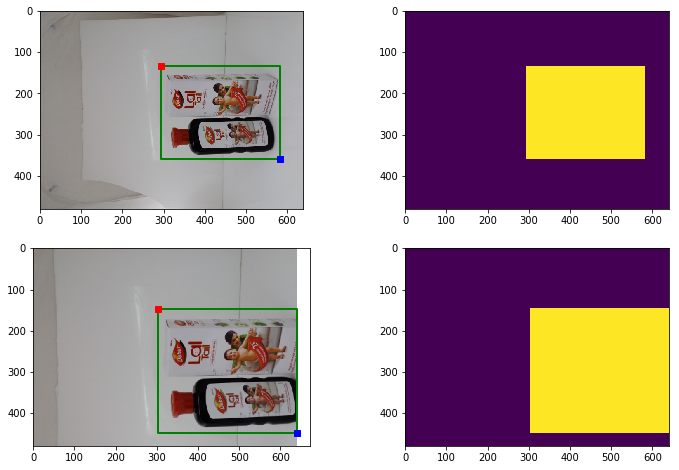

In [11]:
#### Test translation and stretching augmentations

name_str,img,bb_boxes = get_image_name(train_df,1,augmentation=False)
img_mask =get_mask_seg(img,bb_boxes)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)

plt.subplot(2,2,2)
plt.imshow(img_mask[:,:,0])
# plt.axis('off')

plt.subplot(2,2,3)
#bb_boxes1 = bb_boxes.copy()
dst,bb_boxes1 = stretch_image(img,bb_boxes,100)

plt.imshow(dst)

plot_im_bbox(dst,bb_boxes1)

plt.subplot(2,2,4)
img_mask2 =get_mask_seg(dst,bb_boxes1)
plt.imshow(img_mask2[:,:,0])
# plt.axis('off')

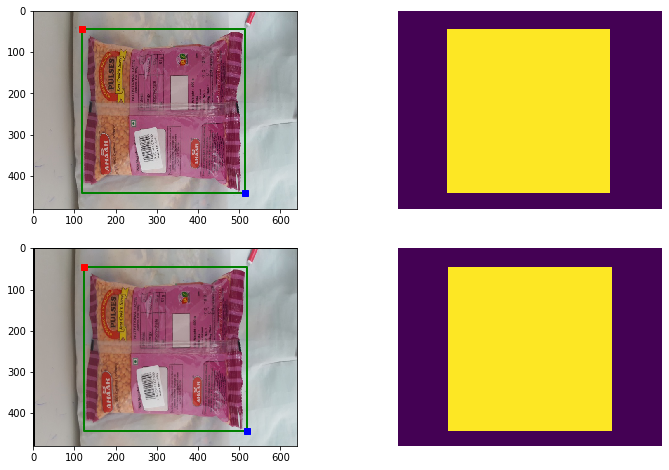

In [114]:
#### Test translation and stretching augmentations

name_str,img,bb_boxes = get_image_name(train_df,200,augmentation=False)
img_mask =get_mask_seg(img,bb_boxes)

plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)

plt.subplot(2,2,2)
plt.imshow(img_mask[:,:,0])
plt.axis('off')

plt.subplot(2,2,3)
#bb_boxes1 = bb_boxes.copy()
img_trans,bb_boxes1 = trans_image(img,bb_boxes,100)

plt.imshow(img_trans)

plot_im_bbox(img_trans,bb_boxes1)
img_mask2 =get_mask_seg(img_trans,bb_boxes1)

plt.subplot(2,2,4)
plt.imshow(img_mask2[:,:,0])
plt.axis('off');

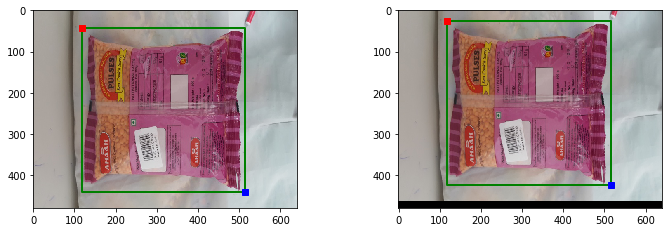

In [115]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plot_im_bbox(img,bb_boxes)
plt.subplot(2,2,2)
#bb_boxes1 = bb_boxes.copy()
img_trans,bb_boxes1 = trans_image(img,bb_boxes,50)
plt.imshow(img_trans)
plot_im_bbox(img_trans,bb_boxes1)


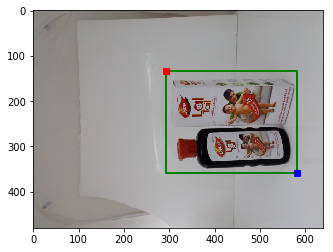

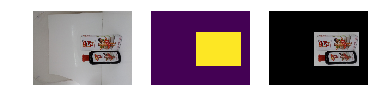

In [116]:
#### Put all the augmentations in 1 function with a flag for augmentation


name_str,img,bb_boxes = get_image_name(train_df,1,augmentation=False)
img_mask =get_mask_seg(img,bb_boxes)


plt.figure(figsize=(6,4))
plt.imshow(img)
plot_im_bbox(img,bb_boxes)
plt.show()

plot_im_mask(img,img_mask)

In [117]:
#### Training generator, generates augmented images
def generate_train_batch(data,batch_size = 32):
    
    batch_images = np.zeros((batch_size, img_rows, img_cols, 3))
    batch_masks = np.zeros((batch_size, img_rows, img_cols, 1))
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data)-2000)
            name_str,img,bb_boxes = get_image_name(train_df,i_line,
                                                   size=(img_cols, img_rows),
                                                  augmentation=True,
                                                   trans_range=50,
                                                   scale_range=50
                                                  )
            img_mask = get_mask_seg(img,bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] =img_mask
        yield batch_images, batch_masks
        
#### Testing generator, generates augmented images
def generate_test_batch(data,batch_size = 32):
    batch_images = np.zeros((batch_size, img_rows, img_cols, 3))
    batch_masks = np.zeros((batch_size, img_rows, img_cols, 1))
    while 1:
        for i_batch in range(batch_size):
            i_line = np.random.randint(len(data)-200)
            name_str,img,bb_boxes = get_image_name(test_df,i_line,
                                                   size=(img_cols, img_rows),
                                                   augmentation=False,
                                                   trans_range=0,
                                                   scale_range=0)
            img_mask = get_mask_seg(img,bb_boxes)
            batch_images[i_batch] = img
            batch_masks[i_batch] =img_mask
        yield batch_images, batch_masks

In [119]:
##### Image size, 
img_rows = 480
img_cols = 640

In [120]:
##### Testing the generator


training_gen = generate_train_batch(train_df,32)

In [121]:
batch_img,batch_mask = next(training_gen)
# batch_mask

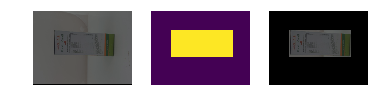

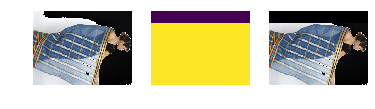

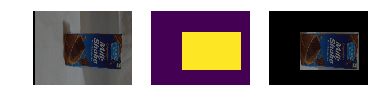

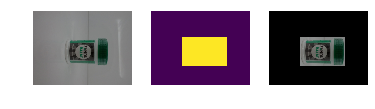

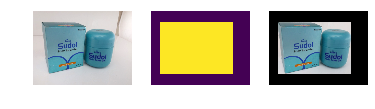

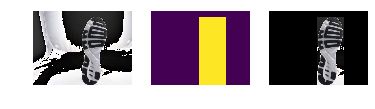

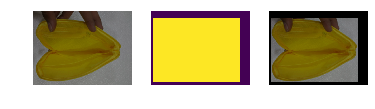

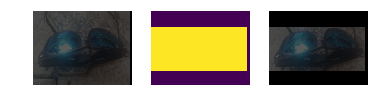

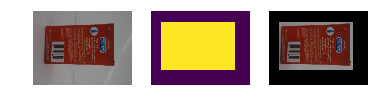

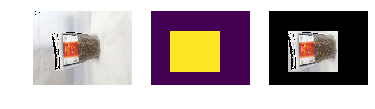

In [122]:
### Plotting generator output
for i in range(10):
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(batch_mask[i],dtype=np.uint8)
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(im_mask[:,:,0])
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(cv2.bitwise_and(im,im,mask=im_mask));
    plt.axis('off')
    plt.show();

In [123]:
len(train_df)
len(test_df)

1400

In [124]:
### IOU or dice coeff calculation

def IOU_calc(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    
    return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def IOU_calc_loss(y_true, y_pred):
    return -IOU_calc(y_true, y_pred)

In [125]:
### Defining a small Unet
### Smaller Unet defined so it fits in memory

def get_small_unet():
    inputs = Input((img_rows, img_cols,3))
    inputs_norm = Lambda(lambda x: x/127.5 - 1.)
    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=3)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=3)
    conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=3)
    conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    
    return model

In [126]:
### Generator 

training_gen = generate_train_batch(train_df,1)
smooth = 1.
model = get_small_unet()
model.compile(optimizer=Adam(lr=0.2), 
              loss=IOU_calc_loss, metrics=[IOU_calc])

In [127]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 480, 640, 3)  0                                            
__________________________________________________________________________________________________
conv2d_153 (Conv2D)             (None, 480, 640, 8)  224         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_154 (Conv2D)             (None, 480, 640, 8)  584         conv2d_153[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_33 (MaxPooling2D) (None, 240, 320, 8)  0           conv2d_154[0][0]                 
__________________________________________________________________________________________________
conv2d_155

In [128]:
### Using previously trained data. Set load_pretrained = False, increase epochs and train for full training.
load_pretrained = True
if load_pretrained == True:
    model.load_weights("uNet-0.89.h5")

checkpoint = ModelCheckpoint("uNet-{val_IOU_calc:.2f}.h5", monitor="val_IOU_calc", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1)

reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")

In [129]:
history = model.fit_generator(training_gen,
                              steps_per_epoch=1000, 
                              epochs=10,
                              validation_data = generate_test_batch(test_df,40),
                              validation_steps = 70,
                              callbacks=[checkpoint])

Epoch 1/1
50/50 [==============================] - 43s 863ms/step - loss: -0.8831 - IOU_calc: 0.8831 - val_loss: -0.8251 - val_IOU_calc: 0.8251

Epoch 00001: val_IOU_calc improved from -inf to 0.82513, saving model to uNet-0.83.h5


In [ ]:
### Save model for use in detection pipeline

model.save('model_save.h5')

In [ ]:
# ### Plot model using Keras 

# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model.png')
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [29]:
### Save weights 
model.save_weights("model_weights.h5", overwrite=True)

In [30]:
### Testing generator

testing_gen = generate_test_batch(test_df,20)


In [31]:
np.shape(im)

(480, 640, 3)

In [32]:
import time

start = time.time()

pred_all= model.predict(batch_img)
end = time.time()
end-start

0.6082777976989746

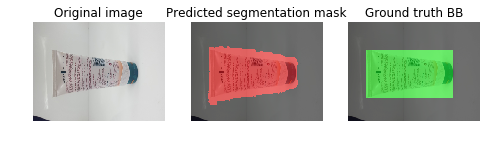

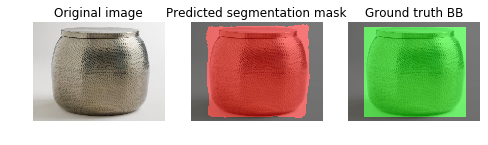

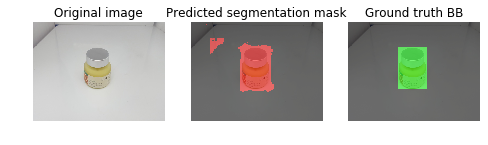

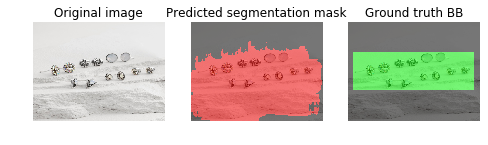

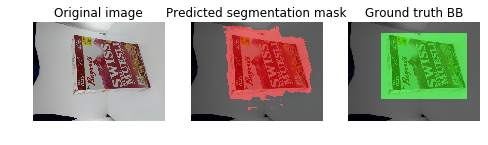

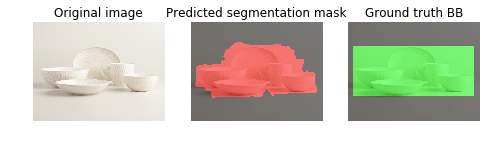

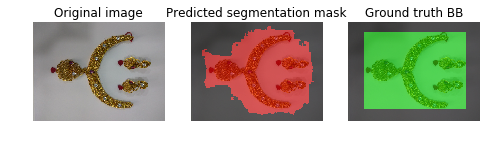

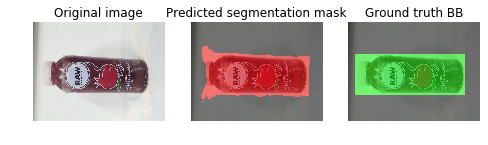

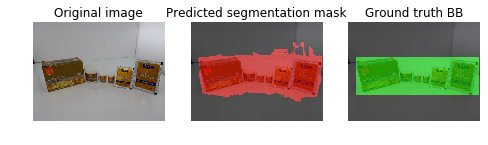

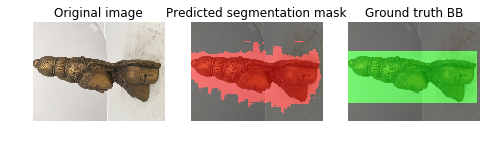

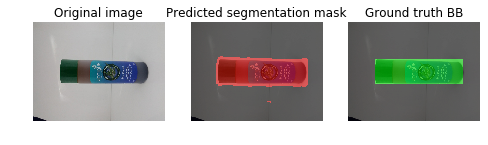

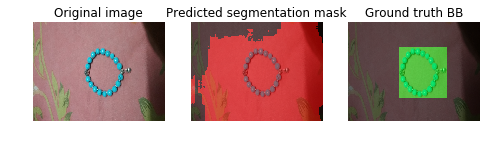

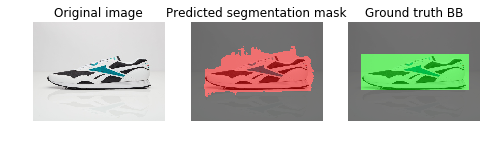

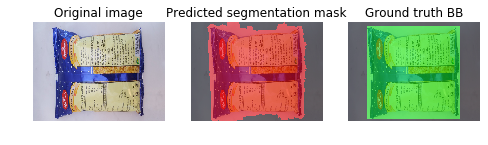

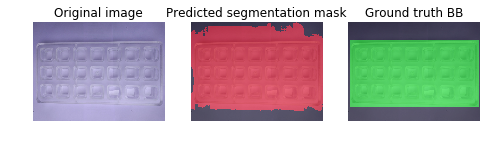

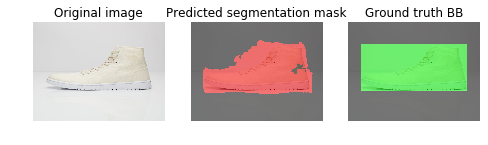

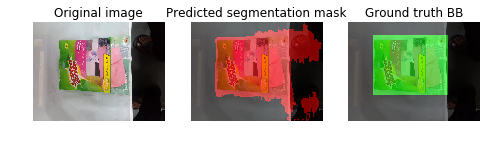

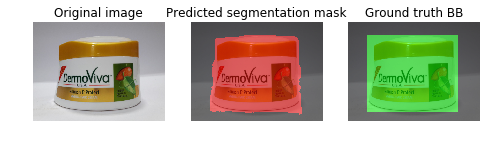

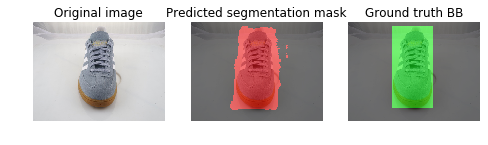

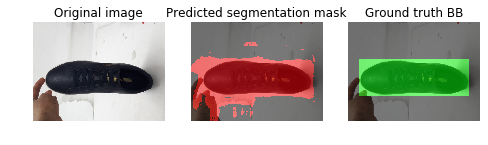

In [134]:
### Test on last frames of data

batch_img,batch_mask = next(testing_gen)
pred_all= model.predict(batch_img)
np.shape(pred_all)

for i in range(20):
    
    im = np.array(batch_img[i],dtype=np.uint8)
    im_mask = np.array(255*batch_mask[i],dtype=np.uint8)
    im_pred = np.array(255*pred_all[i],dtype=np.uint8)
    
    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
    rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
    rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]
    
    img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
    img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)
    
    plt.figure(figsize=(8,3))
    plt.subplot(1,3,1)
    plt.imshow(im)
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(img_pred)
    plt.title('Predicted segmentation mask')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.imshow(img_true)
    plt.title('Ground truth BB')
    plt.axis('off')
    plt.show()


In [130]:
#### Function for drawing bounding boxes, taken from Ryan's code on Udacity

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        if ((np.max(nonzeroy)-np.min(nonzeroy)>50) & (np.max(nonzerox)-np.min(nonzerox)>50)):
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image       
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255),6)
    # Return the image
    return img

def test_new_img(img):
    img = cv2.resize(img,(img_cols, img_rows))
    img = np.reshape(img,(1,img_rows, img_cols,3))
    pred = model.predict(img)
    return pred,img[0]

def get_BB_new_img(img):
    # Take in RGB image
    pred,img = test_new_img(img)
    img  = np.array(img,dtype= np.uint8)
    img_pred = np.array(255*pred[0],dtype=np.uint8)
    heatmap = im_pred[:,:,0]
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [131]:
### Test on new image

test_img = '../../../images/JPEG_20160624_135055_1000527160000.png'
im = cv2.imread(test_img)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)

draw_img = get_BB_new_img(im)


In [ ]:
# test_img = 'test_images/test1.jpg'
im = cv2.imread(test_img)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
pred,im = test_new_img(im)
im  = np.array(im,dtype= np.uint8)
im_pred = np.array(255*pred[0],dtype=np.uint8)
rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
im_mask = np.array(255*batch_mask[0],dtype=np.uint8)
rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]


img_pred = cv2.addWeighted(rgb_mask_pred,0.55,im,1,0)
img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)


#     im = np.array(batch_img[i],dtype=np.uint8)
#     im_mask = np.array(255*batch_mask[i],dtype=np.uint8)
#     im_pred = np.array(255*pred_all[i],dtype=np.uint8)
    
#     rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
#     rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
#     rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
#     rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
#     rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]
    
#     img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
#     img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)

#heatmap = im_pred[:,:,0]

#labels = label(heatmap)
# Draw bounding boxes on a copy of the image
#draw_img = draw_labeled_bboxes(np.copy(im), labels)
# Display the image
#img_pred = im
#im_pred[:,:,]

draw_img = get_BB_new_img(im)
draw_true = get_BB_new_img(image)

plt.figure(figsize=(10,5))
plt.subplot(1,4,1)
plt.imshow(im)
plt.title('Original')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(img_pred)
plt.title('Segmentation')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(draw_img)
plt.title('Bounding Box')
plt.axis('off');
plt.subplot(1,4,4)
plt.imshow(draw_true)
plt.title('Bounding Box')
plt.axis('off');




In [37]:
#### EXTRA STUFF THAT I DIDNT USE. 

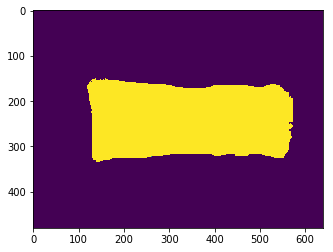

In [38]:
plt.imshow(im_pred[:,:,0])



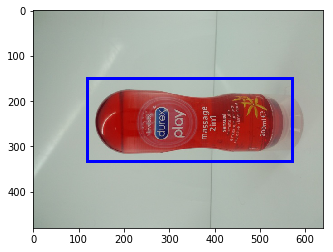

In [39]:

heatmap = im_pred[:,:,0]

labels = label(heatmap)
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(im), labels)
# Display the image
plt.imshow(draw_img)
# plt.axis('off');

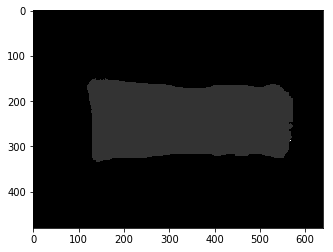

In [40]:
plt.imshow(labels[0],cmap='gray')

In [41]:
np.unique(labels[0])

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [42]:
car_label = 1

blob_non0 = (car_label == labels[0])

img_0 = np.copy(heatmap)*0
img_0[blob_non0] = 255

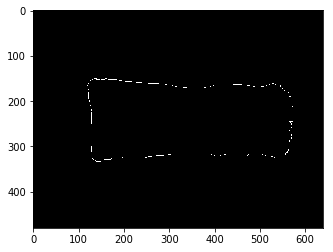

In [43]:
plt.imshow(blob_non0)
img_cny = cv2.Canny(img_0,128,255)
plt.imshow(img_cny,cmap='gray')

In [ ]:
a 